In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Feature Values

In [ ]:
values_mapping = {
    'WALS 116A': ['interrogative intonation only',
                  'interrogative word order',
                  'clause-initial question particle',
                  'clause-final question particle',
                  'clause-medial question particle',
                  'interrogative verb morphology',
                  'tone'],
    'WALS 81A': ['not mentioned in the grammar', 'svo', 'sov', 'vos', 'vso', 'osv', 'ovs', 'no dominant order'],
    'GB 107': ['0', '1'],
    'WALS 49A': ['no morphological case-marking', '2 cases', '3 cases',
                '4 cases', '5 cases', '6-7 cases', '8-9 cases',
                '10 or more cases', 'exclusively borderline case-marking'],
}

## Table for Metric Aggregation

In [ ]:
all_features = ['WALS 81A', 'GB 107', 'WALS 49A'] + values_mapping['WALS 116A']
columns = pd.MultiIndex.from_product([all_features, ['micro', 'macro', 'weighted']],
                                     names=['feature', 'F1 average'])
index = pd.Index([
    'wikipedia_default', 'wikipedia_with_guidelines',
    'reranker_default', 'reranker_with_guidelines',
    'ablation_default', 'ablation_with_guidelines'
    ])
df_metrics = pd.DataFrame(columns=columns, index=index)

## Extracting Values from GPT Responses

In [ ]:
wals_116a_regex = 'interrogative intonation only: ([01]), interrogative word order: ([01]), clause-initial question particle: ([01]), clause-final question particle: ([01]), clause-medial question particle: ([01]), interrogative verb morphology: ([01]), tone: ([01])'
wals_116a_default_value = 'interrogative intonation only: 0, interrogative word order: 0, clause-initial question particle: 0, clause-final question particle: 0, clause-medial question particle: 0, interrogative verb morphology: 0, tone: 0'

In [ ]:
def get_preds(feature, response):
    preds = []
    if feature == 'WALS 116A':
        for i, item in enumerate(response):
            match_result = re.search(wals_116a_regex, item)
            if match_result is None:
                preds.append('')
            else:
                preds.append(match_result.group())
    else:
        for i, item in enumerate(response):
            if len(item) == 0:
                preds.append('')
            else:
                item = re.sub('[*#."]', '', item)
                split_tokens = item.split('conclusion:')

                if feature != 'GB 107':
                    new_split_tokens = []
                    for item in split_tokens:
                        if any(c.isalpha() for c in item):
                            new_split_tokens.append(item)
                else:
                    new_split_tokens = split_tokens

                if len(new_split_tokens[0]) < len(new_split_tokens[-1]):
                    conclusion = new_split_tokens[0].lstrip()
                else:
                    conclusion = new_split_tokens[-1].lstrip()

                conclusion = conclusion.split('\n')
                if len(conclusion[0]) < len(conclusion[-1]):
                    preds.append(conclusion[0].lstrip())
                else:
                    preds.append(conclusion[-1].lstrip())
    return preds

In [ ]:
def find_abnormal_preds(feature, response, preds):
    values = values_mapping[feature]
    if feature == 'WALS 116A':
        for i, pred in enumerate(preds):
            if len(pred) == 0 and len(response[i]) > 0:
                print('abnormal value', i)
    else:
        for i, pred in enumerate(preds):
            if pred not in values:
                replaced = False
                for value in values:
                    if value in pred:
                        preds[i] = value
                        replaced = True
                        break
                if not replaced:
                    if len(response[i]) > 0:
                        print(f'abnormal value {i}: {pred}')
                    preds[i] = ''
    return preds

In [ ]:
def find_errors_in_files():
    for subdir, dirs, files in os.walk('/content/drive/MyDrive/RAG Results'):
        for filename in sorted(files):
            if 'ablation' in filename and filename.endswith('.csv'):
                feature = Path(subdir).parts[-1]
                file_path = os.path.join(subdir, filename)
                df = pd.read_csv(file_path, dtype='str').fillna('')
                response = [item.lower() for item in df['Response'].values]
                print(file_path)
                ## if the column with (potentially fixed) predictions already exists
                if 'Predicted' in df:
                    preds = df['Predicted'].values
                else:
                    ground_truth = df['Target'].values
                    preds = get_preds(feature, response)
                df['Predicted'] = find_abnormal_preds(feature, response, preds)
                df.to_csv(file_path, index=False)
        print()

In [ ]:
find_errors_in_files()


/content/drive/MyDrive/RAG Results/GB 107/ablation_default.csv
/content/drive/MyDrive/RAG Results/GB 107/ablation_with_guidelines.csv
abnormal value 3: 
abnormal value 18: 

/content/drive/MyDrive/RAG Results/WALS 49A/ablation_default.csv
abnormal value 92: 
/content/drive/MyDrive/RAG Results/WALS 49A/ablation_with_guidelines.csv

/content/drive/MyDrive/RAG Results/WALS 81A/ablation_default.csv
/content/drive/MyDrive/RAG Results/WALS 81A/ablation_with_guidelines.csv

/content/drive/MyDrive/RAG Results/WALS 116A/ablation_default.csv
/content/drive/MyDrive/RAG Results/WALS 116A/ablation_with_guidelines.csv
abnormal value 27



### Values that replace missing or unintelligible results:

WALS 116A: all zeroes

WALS 81A: Not mentioned in the grammar

GB 107: 0

WALS 49A: No morphological case-marking

In [ ]:
def fix_preds_manually(file_path, correct_values_dict):
    full_path = os.path.join('/content/drive/MyDrive/RAG Results/', file_path)
    df = pd.read_csv(full_path, dtype='str')
    for index in correct_values_dict:
        df.at[index, 'Predicted'] = correct_values_dict[index]
    df.to_csv(full_path, index=False)

In [ ]:
fix_preds_manually('GB 107/ablation_with_guidelines.csv', {3: '1', 18: '1'})

fix_preds_manually('WALS 49A/ablation_default.csv', {92: 'no morphological case-marking'})

fix_preds_manually('WALS 116A/ablation_with_guidelines.csv', {
                                        27: 'interrogative intonation only: 0, interrogative word order: 0, clause-initial question particle: 1, clause-final question particle: 0, clause-medial question particle: 1, interrogative verb morphology: 0, tone: 0',
                                    })

In [ ]:
find_errors_in_files()


/content/drive/MyDrive/RAG Results/GB 107/ablation_default.csv
/content/drive/MyDrive/RAG Results/GB 107/ablation_with_guidelines.csv

/content/drive/MyDrive/RAG Results/WALS 49A/ablation_default.csv
/content/drive/MyDrive/RAG Results/WALS 49A/ablation_with_guidelines.csv

/content/drive/MyDrive/RAG Results/WALS 81A/ablation_default.csv
/content/drive/MyDrive/RAG Results/WALS 81A/ablation_with_guidelines.csv

/content/drive/MyDrive/RAG Results/WALS 116A/ablation_default.csv
/content/drive/MyDrive/RAG Results/WALS 116A/ablation_with_guidelines.csv



In [ ]:
def transform_polar_questions_into_7_features(ground_truth, preds):
    ground_truth_dict = {}
    preds_dict = {}
    for value in values_mapping['WALS 116A']:
        ground_truth_dict[value] = []
        preds_dict[value] = []
    for i in range(len(ground_truth)):
        ground_truth[i] = ground_truth[i].replace('second position', 'clause-medial')
        for value in values_mapping['WALS 116A']:
            if value in ground_truth[i]:
                ground_truth_dict[value].append('1')
            else:
                ground_truth_dict[value].append('0')
            if value in preds[i]:
                if preds[i].split(value)[1][2] == '1':
                    preds_dict[value].append('1')
                else:
                    preds_dict[value].append('0')
            else:
                preds_dict[value].append('0')
    return ground_truth_dict, preds_dict

In [ ]:
df_ground_truth = pd.read_csv('/content/drive/MyDrive/ground_truth_rag.csv').fillna('')
df_ground_truth_number_of_cases = pd.read_csv('/content/drive/MyDrive/ground_truth_rag_number_of_cases.csv').fillna('')

In [ ]:
# the indices for grammars with no ground-truth values will always be removed
# for consistency with the ablation metrics
def get_indices_to_remove(feature, baseline):
    if feature == 'WALS 49A':
        ground_truth = df_ground_truth_number_of_cases
    else:
        ground_truth = df_ground_truth

    pages = ground_truth[f'{feature}: PDF Pages'].values
    ground_truth_values = ground_truth[feature].values
    indices_to_remove = [
        i for i, x in enumerate(ground_truth_values) if (baseline and x == 'Not mentioned in the grammar') or len(pages[i]) == 0
    ]
    return indices_to_remove

In [ ]:
def remove_indices(feature, ground_truth, preds, baseline=False):
    indices = get_indices_to_remove(feature, baseline)
    print('Indices of removed entries:', indices)
    ground_truth = [v for i, v in enumerate(ground_truth) if i not in indices]
    preds = [v for i, v in enumerate(preds) if i not in indices]
    return ground_truth, preds

## Plots

In [ ]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

In [ ]:
def make_confusion_matrix(ground_truth, preds):
    conf_matrix = confusion_matrix(ground_truth, preds)

    labels = np.unique(ground_truth + preds)
    for i in range(len(labels)):
        if len(labels[i]) == 3:
            labels[i] = labels[i].upper()
        else:
            labels[i] = labels[i][0].upper() + labels[i][1:]
        labels[i] = labels[i].replace('No dominant order', 'No dom. order')
        labels[i] = labels[i].replace('Not mentioned in the grammar', 'No mention')
        labels[i] = labels[i].replace('Exclusively borderline case-marking', 'Borderline')
        labels[i] = labels[i].replace('No morphological case-marking', 'No marking')
        labels[i] = labels[i].replace('10 or more cases', '10+ cases')

    ax=plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax=ax);

    # labels, title and ticks
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('True values')
    ax.xaxis.set_ticklabels(labels, rotation=45);
    ax.yaxis.set_ticklabels(labels, rotation=45);

In [ ]:
def assign_metric_values(method, feature, ground_truth, preds):
    for f1_type in ['micro', 'macro', 'weighted']:
        df_metrics.at[method, (feature, f1_type)] = f1_score(ground_truth, preds, average=f1_type)
        print(f'{f1_type} F1:', df_metrics.at[method, (feature, f1_type)])

In [ ]:
def get_metrics(feature, method):
    baseline = (method == 'baseline')
    results_filename = method + '.csv'
    df = pd.read_csv(os.path.join(*['/content/drive/MyDrive/RAG Results', feature, results_filename]), dtype='str').fillna('')
    preds = df['Predicted'].values
    response = df['Response'].values
    ground_truth = df['Target'].values
    if feature == 'WALS 116A':
        ground_truth_dict, preds_dict = transform_polar_questions_into_7_features(ground_truth, preds)
        metrics_dict = {}
        for subfeature in values_mapping[feature]:
            print(subfeature)
            ground_truth, preds = ground_truth_dict[subfeature], preds_dict[subfeature]
            ground_truth, preds = remove_indices(feature, ground_truth, preds, baseline)
            assign_metric_values(method, subfeature, ground_truth, preds)
    else:
        ground_truth, preds = remove_indices(feature, ground_truth, preds, baseline)
        assign_metric_values(method, feature, ground_truth, preds)
        make_confusion_matrix(ground_truth, preds)

## WALS 81A: Word Order

### Without reranker, default

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.7352941176470589
macro F1: 0.7060150316419909
weighted F1: 0.7398251168996144


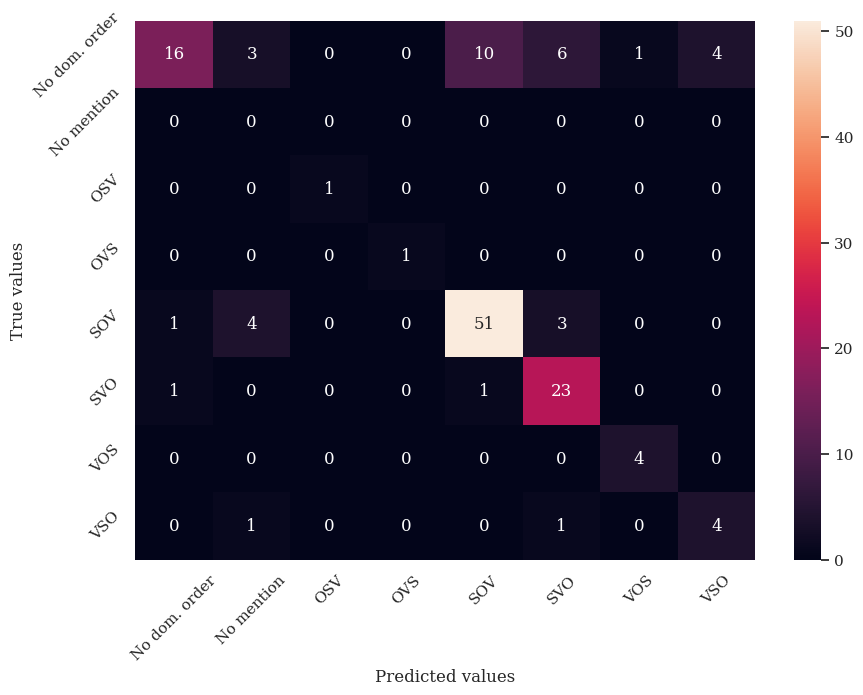

In [ ]:
get_metrics('WALS 81A', 'wikipedia_default')

### Without reranker, with WALS

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.7426470588235294
macro F1: 0.5865705931495404
weighted F1: 0.7498587154159909


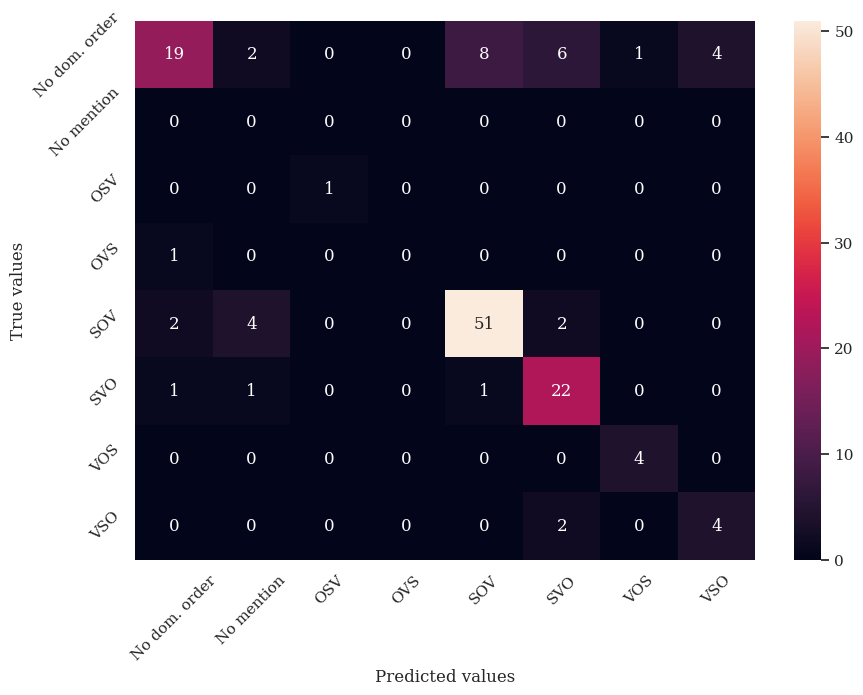

In [ ]:
get_metrics('WALS 81A', 'wikipedia_with_guidelines')

### With reranker, default

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.75
macro F1: 0.5879902728421963
weighted F1: 0.7391409530157491


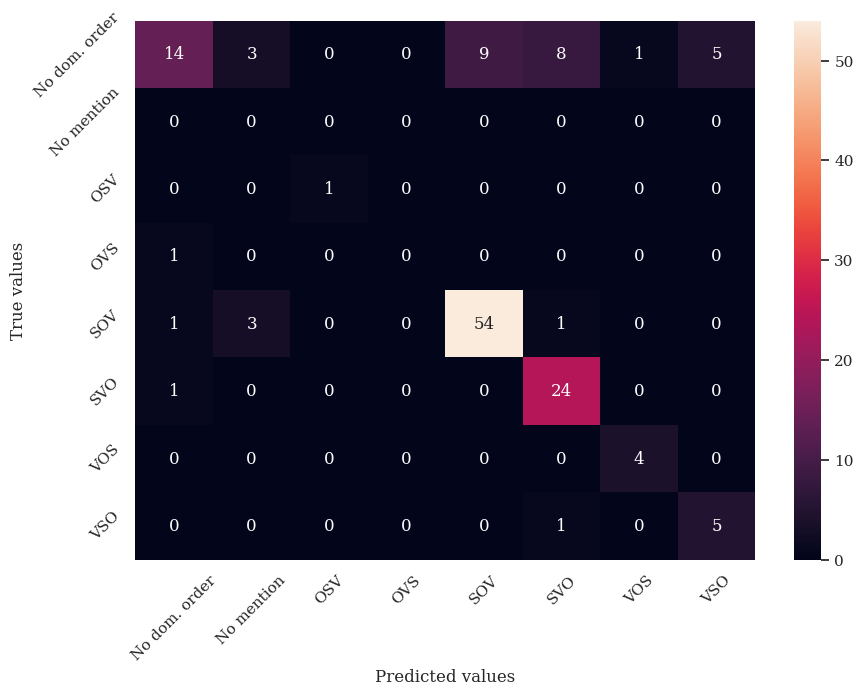

In [ ]:
get_metrics('WALS 81A', 'reranker_default')

### With reranker, with WALS

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.7794117647058824
macro F1: 0.5999772063478249
weighted F1: 0.7720912862000829


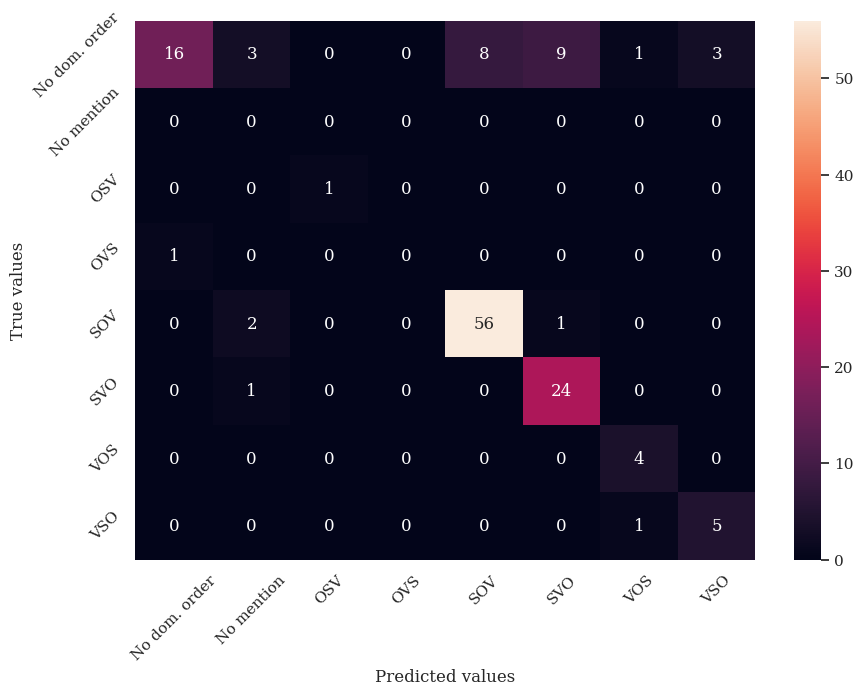

In [ ]:
get_metrics('WALS 81A', 'reranker_with_guidelines')

### Ablation, default

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.7867647058823529
macro F1: 0.519784094474497
weighted F1: 0.7838266925409523


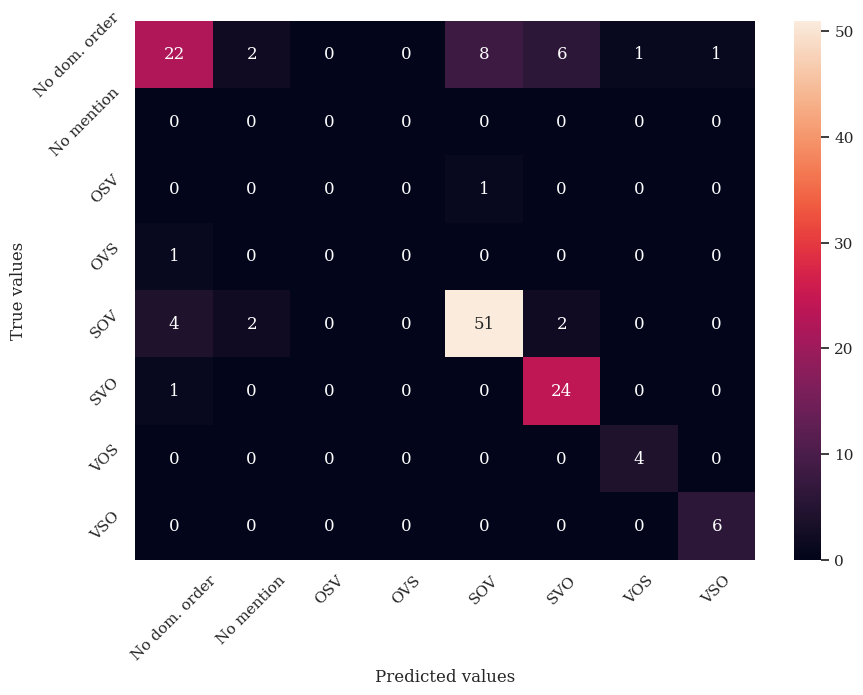

In [ ]:
get_metrics('WALS 81A', 'ablation_default')

### Ablation, with WALS

Indices of removed entries: [17, 24, 27, 34, 42, 69, 71, 72, 77, 78, 97, 100]
micro F1: 0.7867647058823529
macro F1: 0.49488220113220116
weighted F1: 0.793864713717655


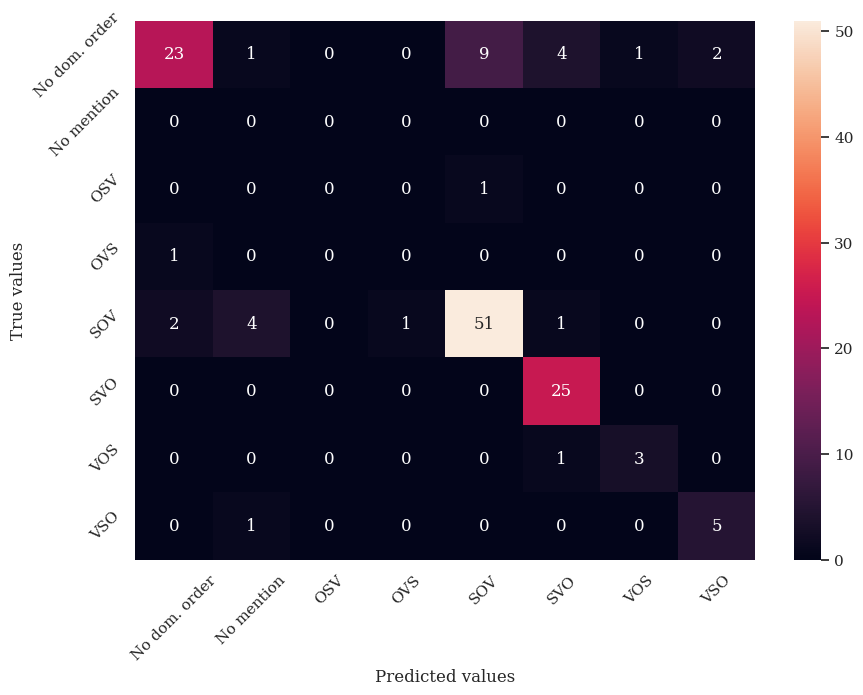

In [ ]:
get_metrics('WALS 81A', 'ablation_with_guidelines')

## GB 107: Can standard negation be marked by an affix, clitic or modification of the verb?

### Without reranker, default

Indices of removed entries: [24, 100]
micro F1: 0.6643835616438356
macro F1: 0.5678646934460888
weighted F1: 0.5958411769816676


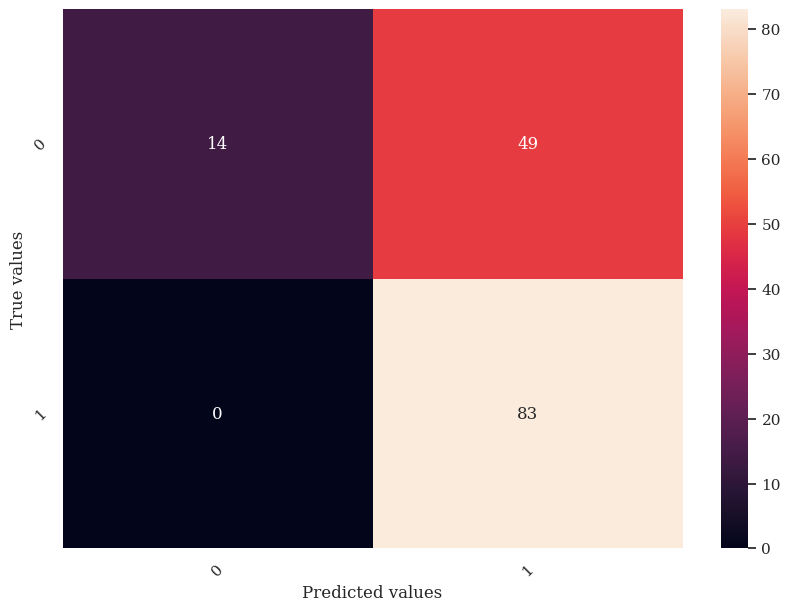

In [ ]:
get_metrics('GB 107', 'wikipedia_default')

### Without reranker, with Grambank

Indices of removed entries: [24, 100]
micro F1: 0.6643835616438356
macro F1: 0.5814171201217015
weighted F1: 0.6069452559746659


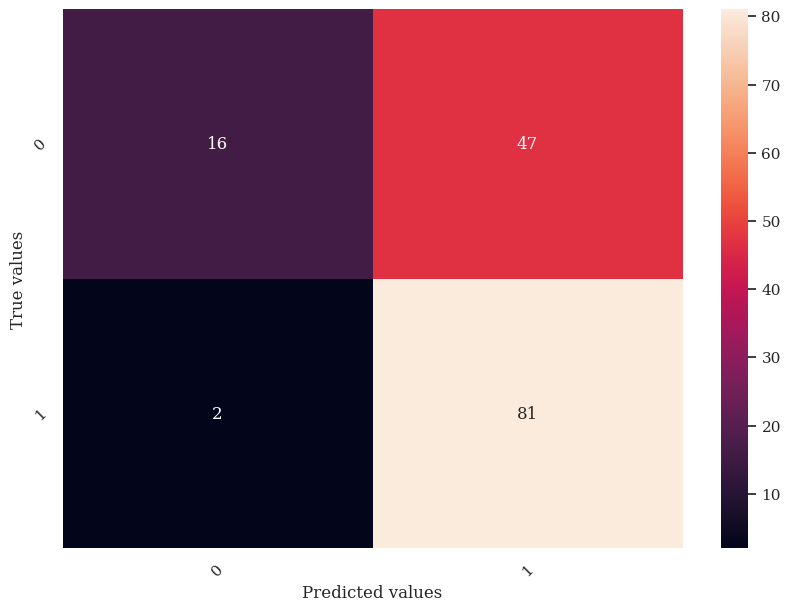

In [ ]:
get_metrics('GB 107', 'wikipedia_with_guidelines')

### With reranker, default

Indices of removed entries: [24, 100]
micro F1: 0.684931506849315
macro F1: 0.6099883855981417
weighted F1: 0.6334081109891334


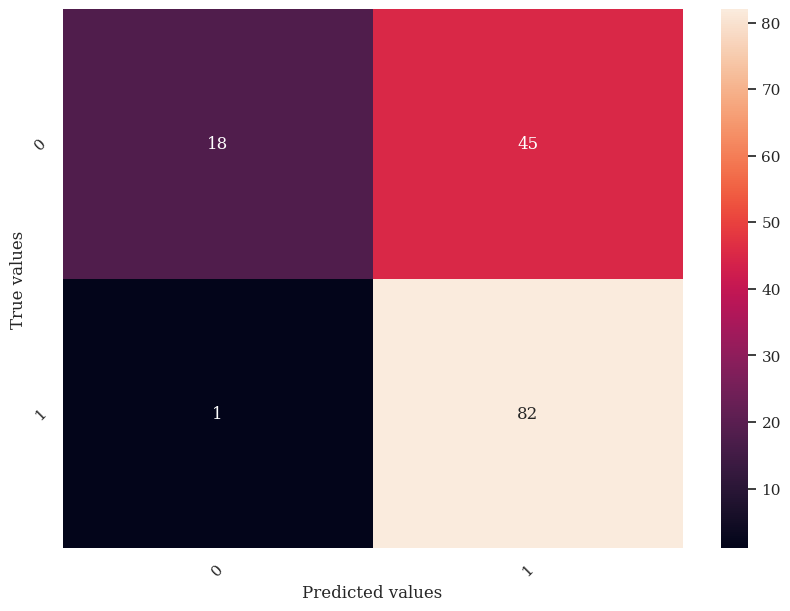

In [ ]:
get_metrics('GB 107', 'reranker_default')

### With reranker, with Grambank

Indices of removed entries: [24, 100]
micro F1: 0.7191780821917808
macro F1: 0.664367816091954
weighted F1: 0.6829475673122344


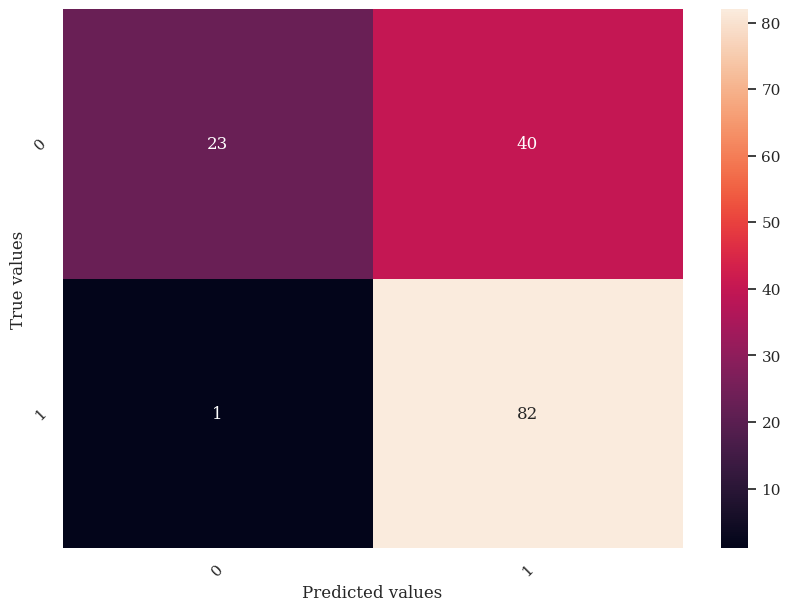

In [ ]:
get_metrics('GB 107', 'reranker_with_guidelines')

### Ablation, default

Indices of removed entries: [24, 100]
micro F1: 0.815068493150685
macro F1: 0.8037927430192624
weighted F1: 0.8102360288086468


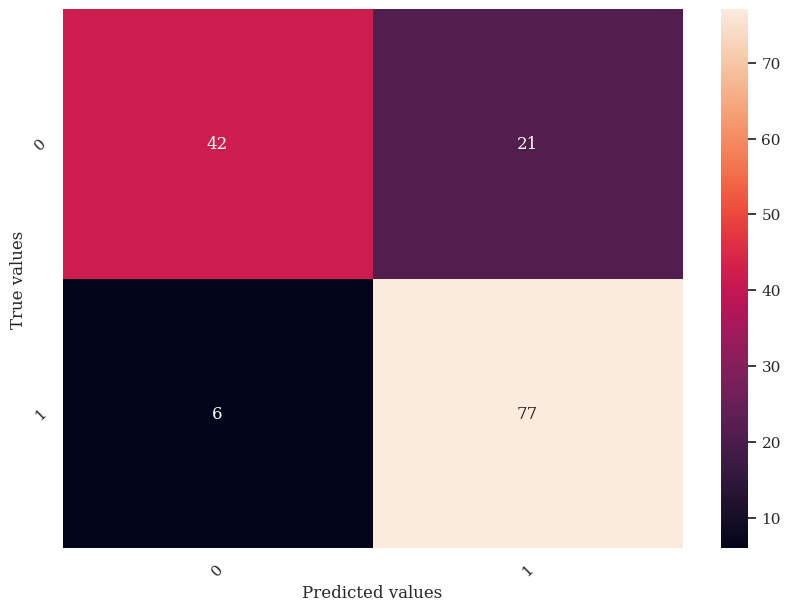

In [ ]:
get_metrics('GB 107', 'ablation_default')

### Ablation, with Grambank

Indices of removed entries: [24, 100]
micro F1: 0.8424657534246576
macro F1: 0.8303612023238192
weighted F1: 0.8365686644268133


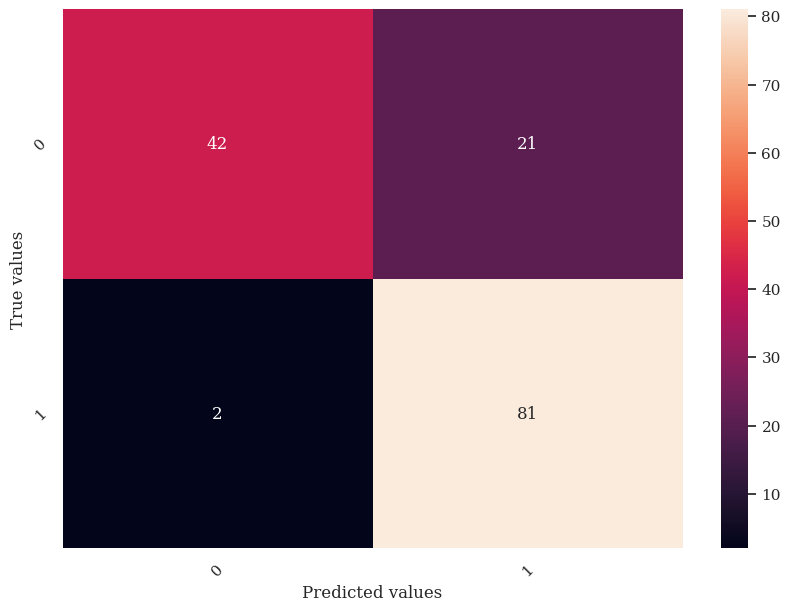

In [ ]:
get_metrics('GB 107', 'ablation_with_guidelines')

## WALS 116A: Polar Questions

### Without reranker, default

In [ ]:
get_metrics('WALS 116A', 'wikipedia_default')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.8347107438016529
macro F1: 0.8346090759978131
weighted F1: 0.8351851935529058
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9917355371900827
macro F1: 0.9422985216976634
weighted F1: 0.9921769391141222
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9008264462809917
macro F1: 0.8126934984520124
weighted F1: 0.8987027607911369
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.71900826446281
macro F1: 0.

### Without reranker, with WALS

In [ ]:
get_metrics('WALS 116A', 'wikipedia_with_guidelines')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.8925619834710744
macro F1: 0.8924444444444444
weighted F1: 0.8929439853076215
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9834710743801653
macro F1: 0.8956896551724138
weighted F1: 0.9850527215730978
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9090909090909091
macro F1: 0.8384904744569834
weighted F1: 0.9099734145238331
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7851239669421488
macro F1: 

### With reranker, default

In [ ]:
get_metrics('WALS 116A', 'reranker_default')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.8429752066115702
macro F1: 0.8429322948691672
weighted F1: 0.8432970446795933
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9834710743801653
macro F1: 0.8707264957264957
weighted F1: 0.9834710743801653
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9421487603305785
macro F1: 0.8972212110180804
weighted F1: 0.9427103546969847
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7024793388429752
macro F1: 

### With reranker, with WALS

In [ ]:
get_metrics('WALS 116A', 'reranker_with_guidelines')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.8677685950413223
macro F1: 0.8676872607982504
weighted F1: 0.8681481548423245
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9752066115702479
macro F1: 0.8268955650929899
weighted F1: 0.9765308173423664
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9256198347107438
macro F1: 0.8678558427375318
weighted F1: 0.9263418846104089
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.7851239669421488
macro F1: 

### Ablation, default

In [ ]:
get_metrics('WALS 116A', 'ablation_default')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9173553719008265
macro F1: 0.9168956043956045
weighted F1: 0.9177640541276905
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9917355371900827
macro F1: 0.9264437689969605
weighted F1: 0.9911628023813711
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9586776859504132
macro F1: 0.9265865792986288
weighted F1: 0.9590788247835605
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.8016528925619835
macro F1: 

### Ablation, with WALS

In [ ]:
get_metrics('WALS 116A', 'ablation_with_guidelines')

interrogative intonation only
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9256198347107438
macro F1: 0.9251083144212915
weighted F1: 0.9259778989133605
interrogative word order
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9834710743801653
macro F1: 0.8707264957264957
weighted F1: 0.9834710743801653
clause-initial question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.9338842975206612
macro F1: 0.8888888888888888
weighted F1: 0.9362217213456883
clause-final question particle
Indices of removed entries: [7, 9, 17, 24, 27, 31, 34, 36, 37, 47, 52, 53, 61, 67, 73, 74, 77, 91, 95, 100, 107, 112, 116, 125, 128, 144, 146]
micro F1: 0.8016528925619835
macro F1: 

## WALS 49A: Number of Cases

### Without reranker, default

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.5
macro F1: 0.46553069920016704
weighted F1: 0.508778292669049


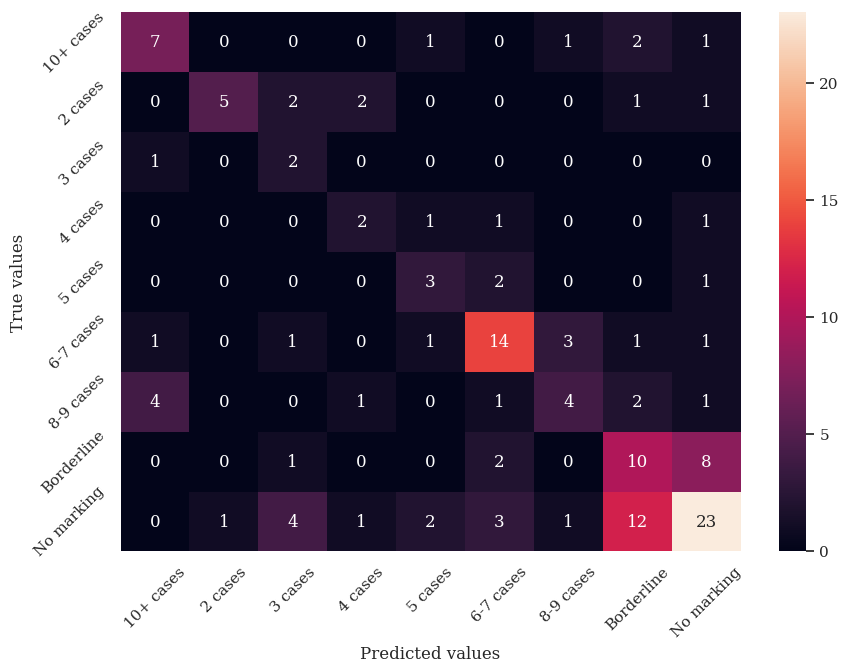

In [ ]:
get_metrics('WALS 49A', 'wikipedia_default')

### Without reranker, with WALS

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.5214285714285715
macro F1: 0.44614226353356795
weighted F1: 0.5341007232932699


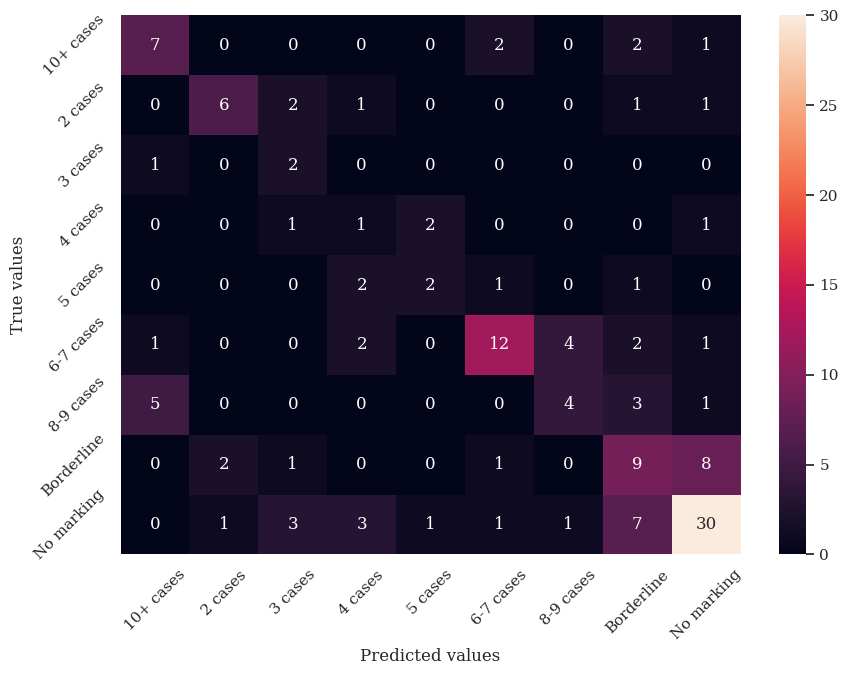

In [ ]:
get_metrics('WALS 49A', 'wikipedia_with_guidelines')

### With reranker, default

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.5357142857142857
macro F1: 0.42987792208487935
weighted F1: 0.5409216910410443


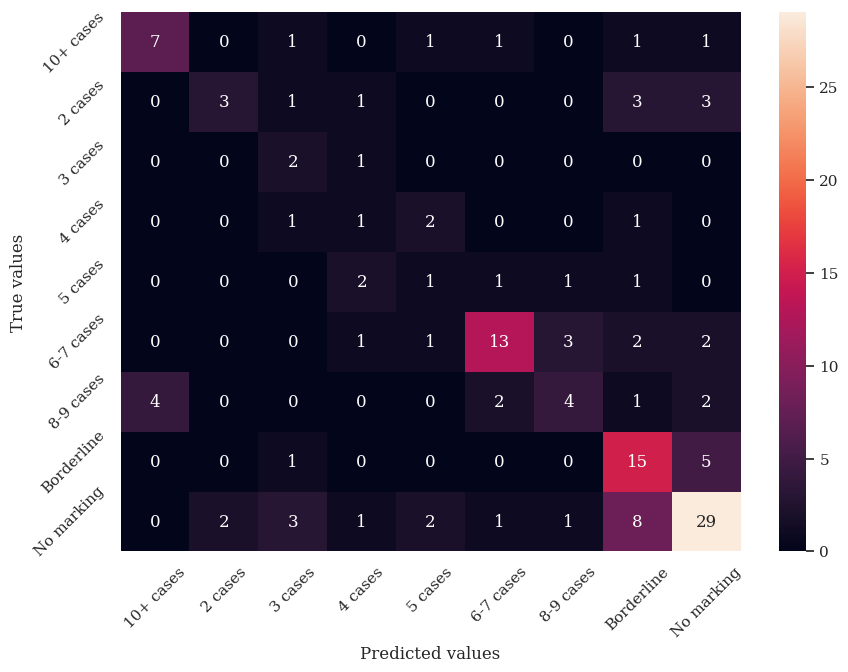

In [ ]:
get_metrics('WALS 49A', 'reranker_default')

### With reranker, with WALS

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.5
macro F1: 0.403101873780723
weighted F1: 0.5022695278996722


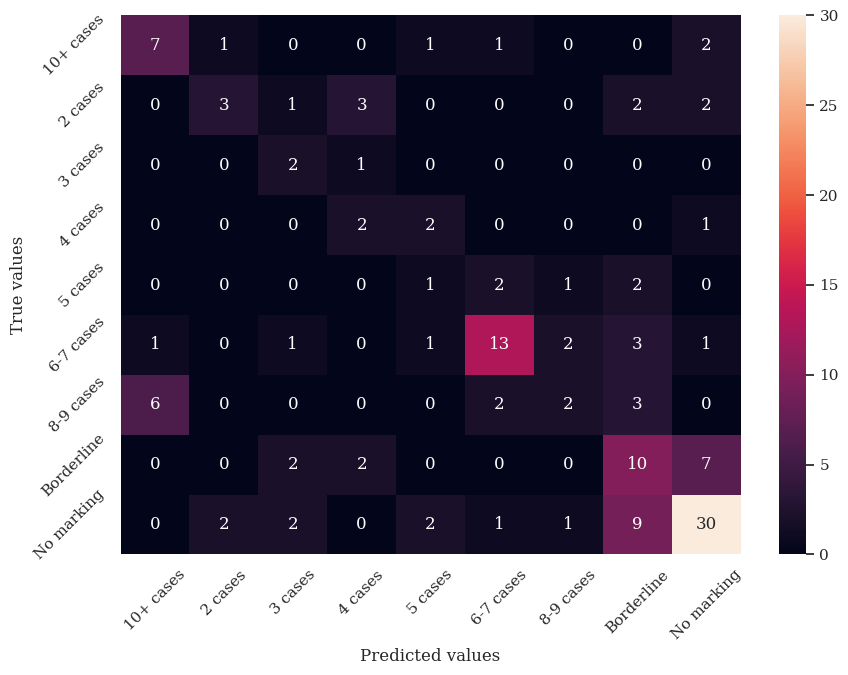

In [ ]:
get_metrics('WALS 49A', 'reranker_with_guidelines')

### Ablation, default

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.5
macro F1: 0.41255576304595915
weighted F1: 0.5082406447427456


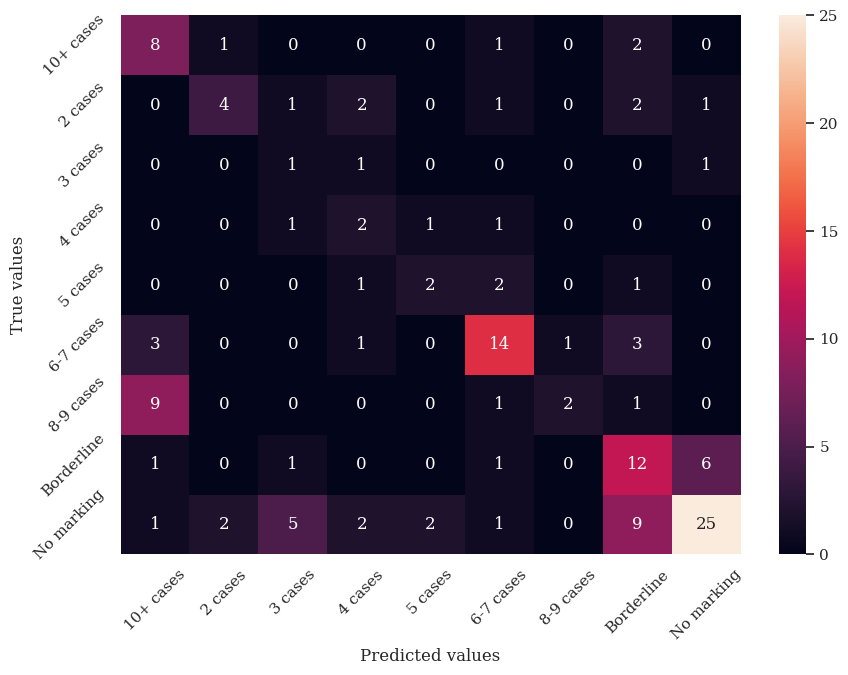

In [ ]:
get_metrics('WALS 49A', 'ablation_default')

### Ablation, with WALS

Indices of removed entries: [12, 19, 24, 34, 56, 89, 91, 108]
micro F1: 0.5428571428571428
macro F1: 0.4736609090300218
weighted F1: 0.557855048338414


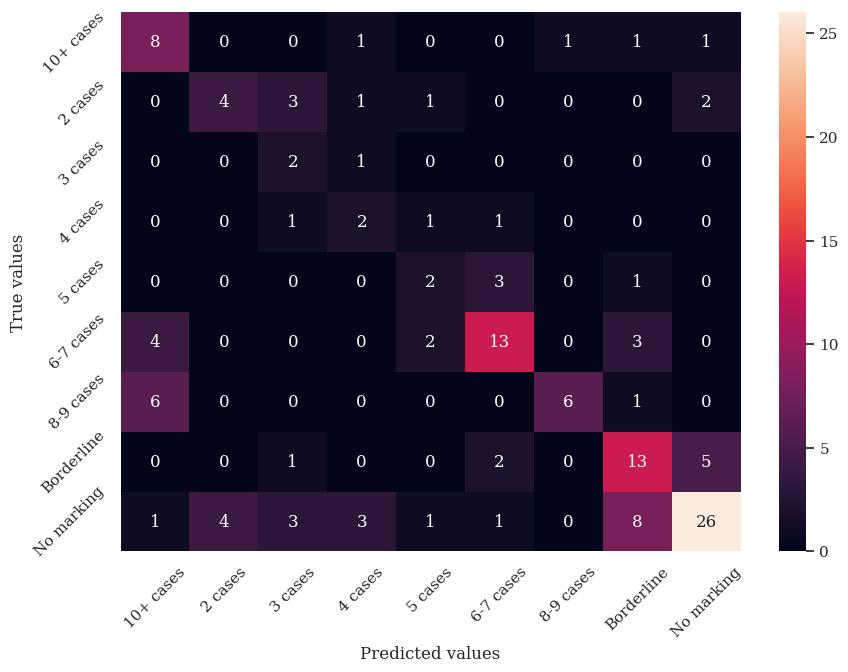

In [ ]:
get_metrics('WALS 49A', 'ablation_with_guidelines')

In [ ]:
df_metrics

feature                   WALS 81A                 GB 107                  \
F1 average                   micro  macro weighted  micro  macro weighted   
wikipedia_default           0.7353 0.7060   0.7398 0.6644 0.5679   0.5958   
wikipedia_with_guidelines   0.7426 0.5866   0.7499 0.6644 0.5814   0.6069   
reranker_default            0.7500 0.5880   0.7391 0.6849 0.6100   0.6334   
reranker_with_guidelines    0.7794 0.6000   0.7721 0.7192 0.6644   0.6829   
ablation_default            0.7868 0.5198   0.7838 0.8151 0.8038   0.8102   
ablation_with_guidelines    0.7868 0.4949   0.7939 0.8425 0.8304   0.8366   

feature                   WALS 49A                  \
F1 average                   micro  macro weighted   
wikipedia_default           0.5000 0.4655   0.5088   
wikipedia_with_guidelines   0.5214 0.4461   0.5341   
reranker_default            0.5357 0.4299   0.5409   
reranker_with_guidelines    0.5000 0.4031   0.5023   
ablation_default            0.5000 0.4126   0.5082   
ablation_with_guidelines    0.5429 0.4737   0.5579   

feature                   interrogative intonation only  ...  \
F1 average                                        micro  ...   
wikipedia_default                                0.8347  ...   
wikipedia_with_guidelines                        0.8926  ...   
reranker_default                                 0.8430  ...   
reranker_with_guidelines                         0.8678  ...   
ablation_default                                 0.9174  ...   
ablation_with_guidelines                         0.9256  ...   

feature                   clause-final question particle  \
F1 average                                      weighted   
wikipedia_default                                 0.7195   
wikipedia_with_guidelines                         0.7874   
reranker_default                                  0.7030   
reranker_with_guidelines                          0.7874   
ablation_default                                  0.8038   
ablation_with_guidelines                          0.8035   

feature                   clause-medial question particle                  \
F1 average                                          micro  macro weighted   
wikipedia_default                                  0.8430 0.7961   0.8502   
wikipedia_with_guidelines                          0.8843 0.8374   0.8857   
reranker_default                                   0.8430 0.7961   0.8502   
reranker_with_guidelines                           0.8595 0.8049   0.8621   
ablation_default                                   0.9091 0.8671   0.9085   
ablation_with_guidelines                           0.9008 0.8606   0.9021   

feature                   interrogative verb morphology                  \
F1 average                                        micro  macro weighted   
wikipedia_default                                0.7686 0.7026   0.7894   
wikipedia_with_guidelines                        0.8099 0.7361   0.8226   
reranker_default                                 0.8017 0.7279   0.8157   
reranker_with_guidelines                         0.8182 0.7506   0.8311   
ablation_default                                 0.8760 0.8188   0.8819   
ablation_with_guidelines                         0.8843 0.8235   0.8877   

feature                     tone                  
F1 average                 micro  macro weighted  
wikipedia_default         0.9174 0.7500   0.9309  
wikipedia_with_guidelines 0.9504 0.8199   0.9555  
reranker_default          0.9587 0.8572   0.9637  
reranker_with_guidelines  0.9669 0.8484   0.9669  
ablation_default          0.9504 0.8199   0.9555  
ablation_with_guidelines  0.9669 0.8662   0.9689  

[6 rows x 30 columns]

In [ ]:
df_metrics.to_csv('/content/drive/MyDrive/rag_metrics_with_ablation.csv')